In [59]:
import random
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import chromadb
from chromadb.utils import embedding_functions
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [21]:
CHROMA_DATA_PATH = "chroma_data/"
EMBED_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
COLLECTION_NAME = "full_docs"
NUM_CLUSTERS = 5  # Adjust the number of clusters as needed
TSNE_PERPLEXITY = 30
TSNE_N_COMPONENTS = 2


In [22]:
# Initialize Chroma client and collection
client = chromadb.PersistentClient(path=CHROMA_DATA_PATH)
embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name=EMBED_MODEL
)

collection = client.get_collection(
    name=COLLECTION_NAME,
)

In [48]:
# Function to get a random sample of n results
def get_random_sample(collection, n_results):
    existing_count = collection.count()
    all_ids = collection.get(include=[])['ids']
    # print(all_ids)
    
    if n_results > existing_count:
        n_results = existing_count  # Limit to the number of existing entries

    random_ids = random.sample(all_ids, n_results)
    random_documents = collection.get(ids=random_ids, include=['embeddings', 'metadatas'])
    # random_documents = collection.get(ids=random_ids)

    return random_documents

In [49]:
# Get all embeddings
data = get_random_sample(collection, 1000)
embeddings = data['embeddings']
print(len(embeddings))
metadata = data['metadatas']
# print(metadata[0:5])
subreddits = {}
for meta in metadata:
    if(meta['subreddit'] in subreddits): subreddits[meta['subreddit']] += 1
    else: subreddits[meta['subreddit']] = 1
sorted_subreddits = sorted(subreddits.items(), key=lambda item: item[1], reverse=True)
top_n_subreddits = {k: v for k, v in sorted_subreddits[:5]}
print(top_n_subreddits)
# Filter embeddings and metadata to include only those from top n subreddits
filtered_embeddings = [emb for emb, meta in zip(embeddings, metadata) if meta['subreddit'] in top_n_subreddits]
filtered_metadata = [meta for meta in metadata if meta['subreddit'] in top_n_subreddits]

print(f"Total embeddings before filtering: {len(embeddings)}")
print(f"Total embeddings after filtering: {len(filtered_embeddings)}")

1000
{'music': 27, 'starwars': 27, 'conservative': 26, 'funny': 24, 'askhistorians': 24}
Total embeddings before filtering: 1000
Total embeddings after filtering: 128


In [50]:
# Convert embeddings to a NumPy array
embeddings_array = np.array(filtered_embeddings)

In [61]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
kmeans.fit(embeddings_array)
labels = kmeans.labels_

C:\Users\yugi9\.conda\envs\RAGDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [62]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=TSNE_N_COMPONENTS, perplexity=TSNE_PERPLEXITY, random_state=42)
tsne_results = tsne.fit_transform(embeddings_array)

In [63]:
# Create a DataFrame for visualization
df = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
df['cluster'] = labels
df['subreddit'] = [meta['subreddit'] for meta in filtered_metadata]

In [64]:
# Analyze the distribution of subreddits within each cluster
cluster_analysis = {}
for cluster in range(NUM_CLUSTERS):
    cluster_subreddits = df[df['cluster'] == cluster]['subreddit']
    subreddit_counts = Counter(cluster_subreddits)
    cluster_analysis[cluster] = subreddit_counts

print("Cluster analysis by subreddit:")
for cluster, counts in cluster_analysis.items():
    print(f"Cluster {cluster}:")
    for subreddit, count in counts.items():
        print(f"  {subreddit}: {count}")

Cluster analysis by subreddit:
Cluster 0:
  askhistorians: 10
  conservative: 2
  music: 1
  starwars: 2
Cluster 1:
  funny: 15
  conservative: 1
  music: 15
  starwars: 9
Cluster 2:
  funny: 3
  askhistorians: 6
  conservative: 7
  music: 1
  starwars: 8
Cluster 3:
  funny: 2
  music: 2
  starwars: 2
Cluster 4:
  funny: 4
  askhistorians: 8
  conservative: 16
  music: 8
  starwars: 6


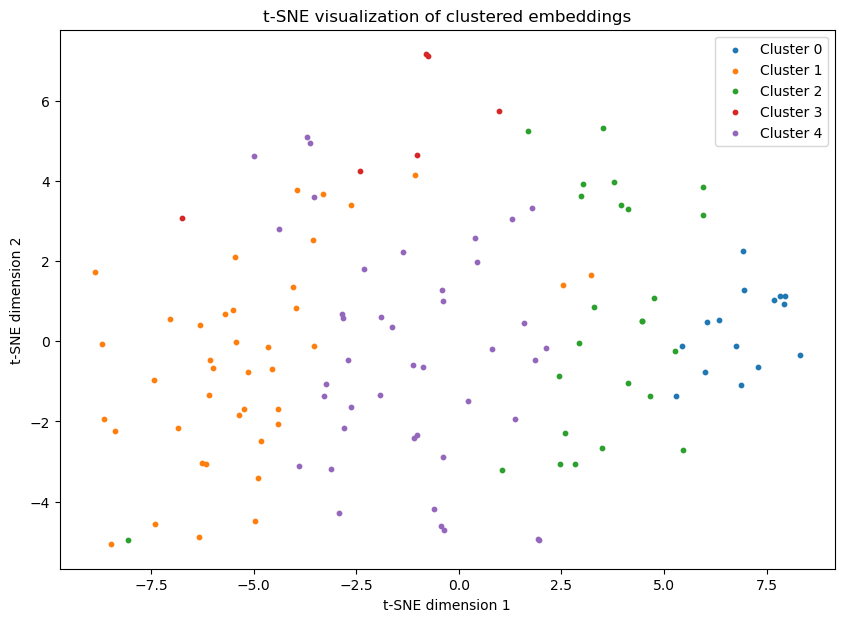

In [65]:
# Plot t-SNE results
plt.figure(figsize=(10, 7))
for cluster in range(NUM_CLUSTERS):
    cluster_data = df[df['cluster'] == cluster]
    plt.scatter(cluster_data['tsne_1'], cluster_data['tsne_2'], label=f'Cluster {cluster}', s=10)

plt.title('t-SNE visualization of clustered embeddings')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend()
plt.show()